In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
import gc
import torch
import torchvision

from torch import nn

from config import (
    IMAGE_DIMENSION_STL,
    EPOCHS_PRO_MAX,
    get_device,
    LEARNING_RATE,
    WEIGHT_DECAY,
)
from utils import download_stl10, get_data_loaders, print_model_summary

print(torch.__version__)
print(torchvision.__version__)


DEVICE: torch.device = get_device()


2.10.0+cu128
0.25.0+cu128
Using DEVICE: cuda


In [3]:
train_dataset, test_dataset = download_stl10(img_dimensions=IMAGE_DIMENSION_STL)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


STL-10 ready  train=5000  test=8000  channels=3

Dataset Statistics:
Training samples: 5000
Testing samples: 8000
Number of classes: 10
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [4]:
train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset, train_dataset=train_dataset, batch_size=64
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


DataLoader Information:
Train batches: 79
Test batches: 125


In [5]:
images, labels = next(iter(train_dataloader))
print(f"Images: {images.shape}")
print(f"Labels: {labels.shape}")

Images: torch.Size([64, 3, 64, 64])
Labels: torch.Size([64])


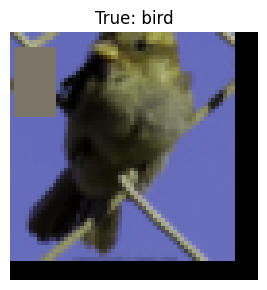

In [6]:
from utils import (
    show_img,
    show_wavelet_subbands,
    show_gabor_responses,
    show_log_responses,
    show_lbp_responses,
    show_dog_responses,
    apply_sobel_for_vis,
    show_img_grayscale,
)

show_img(images[5], labels[5], classes_str=class_names)

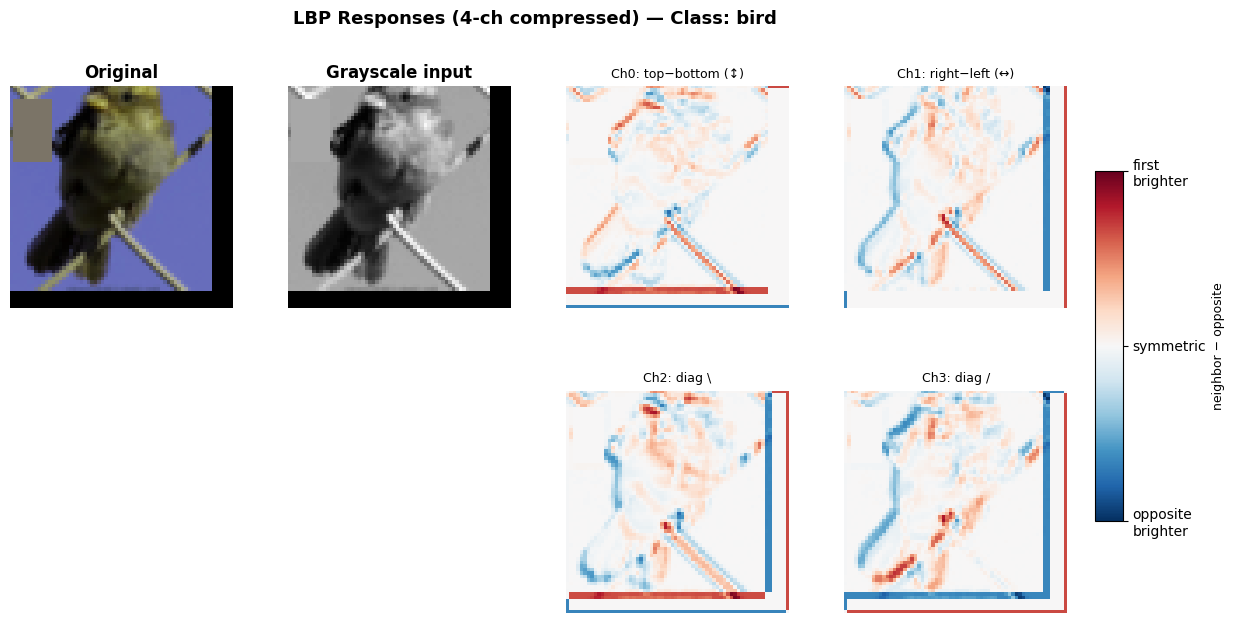

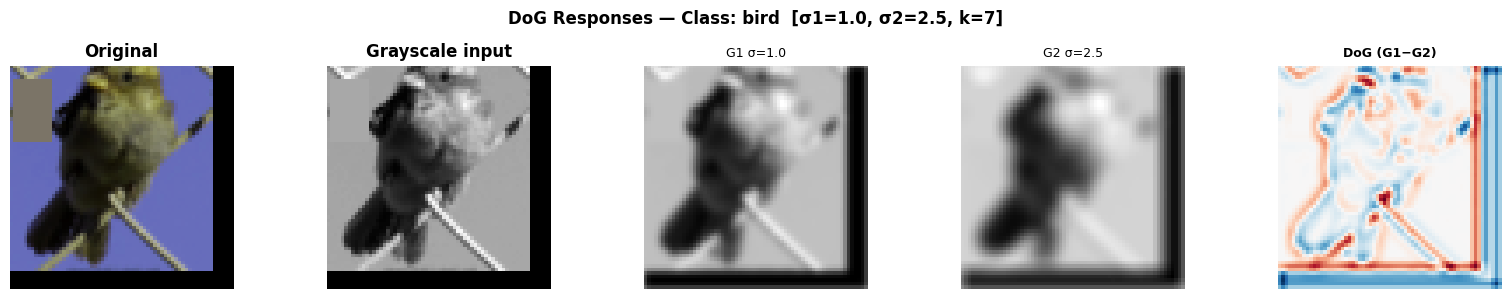

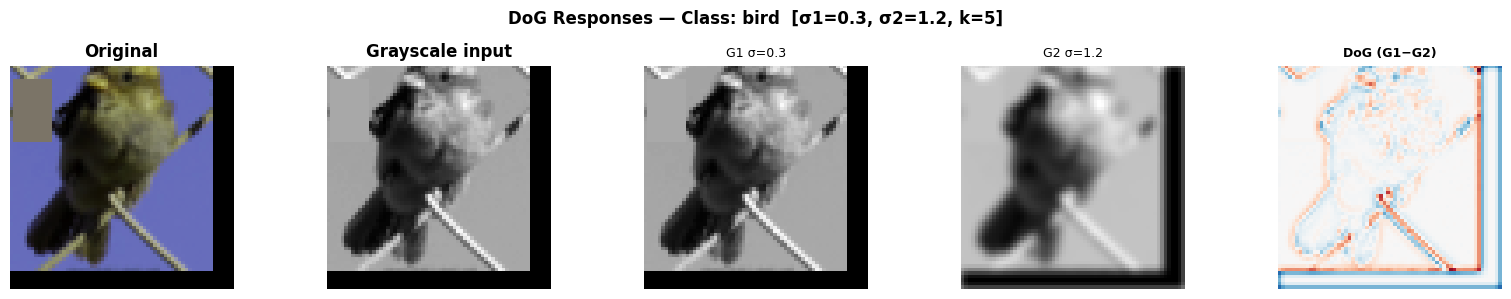

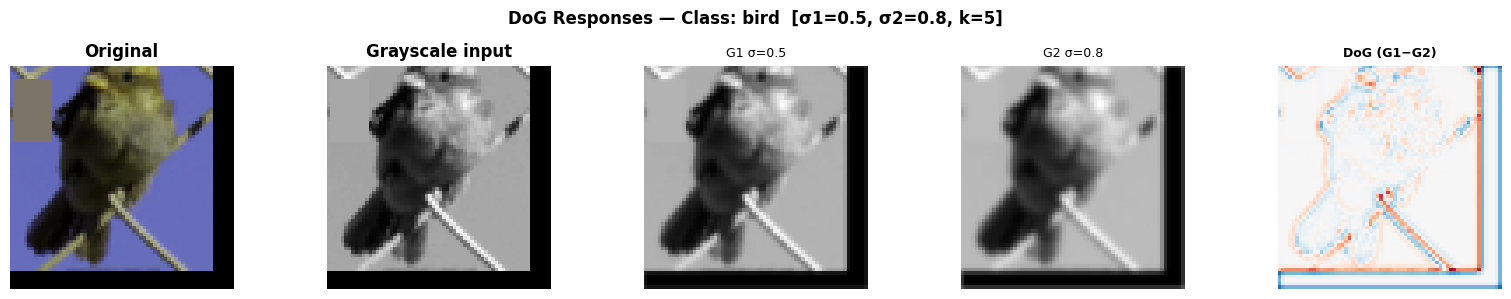

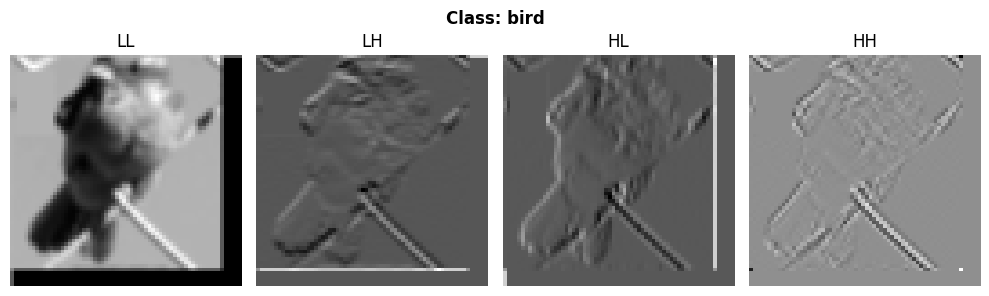

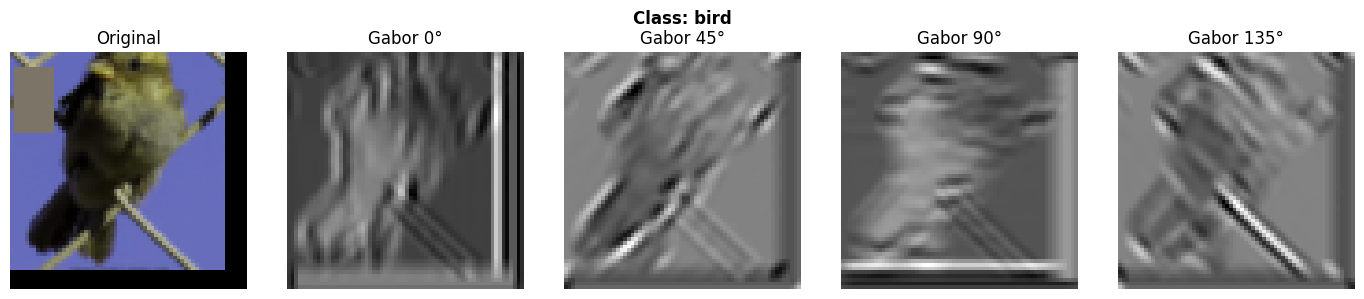

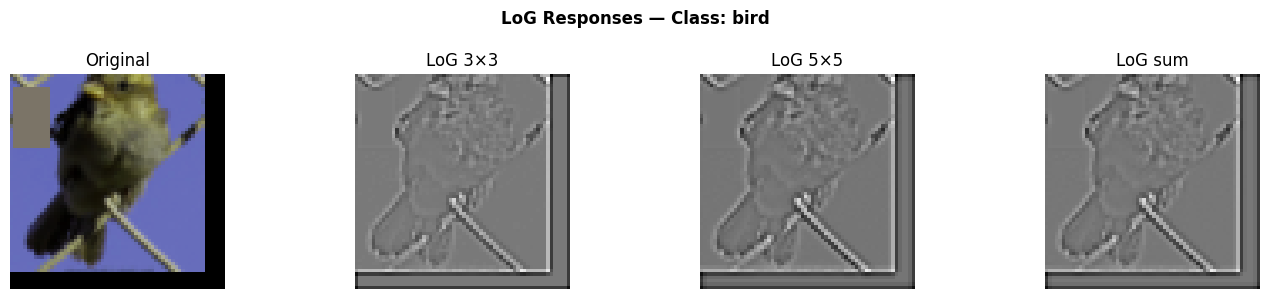

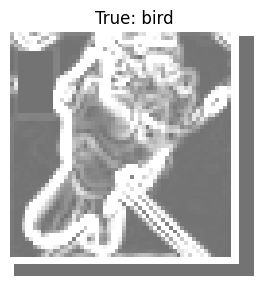

In [7]:
show_lbp_responses(x=images[5], y=labels[5], classes_str=class_names)
show_dog_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
)

show_dog_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
    sigma1=0.3,
    sigma2=1.2,
    kernel_size=5,
)
show_dog_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
    sigma1=0.5,
    sigma2=0.8,
    kernel_size=5,
)

show_wavelet_subbands(x=images[5], y=labels[5], classes_str=class_names)
show_gabor_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
    orientations=(0, 45, 90, 135),
    kernel_size=7,
)
show_log_responses(x=images[5], y=labels[5], classes_str=class_names)
x = apply_sobel_for_vis(images[5])
show_img_grayscale(X=x, y=labels[5], classes_str=class_names)

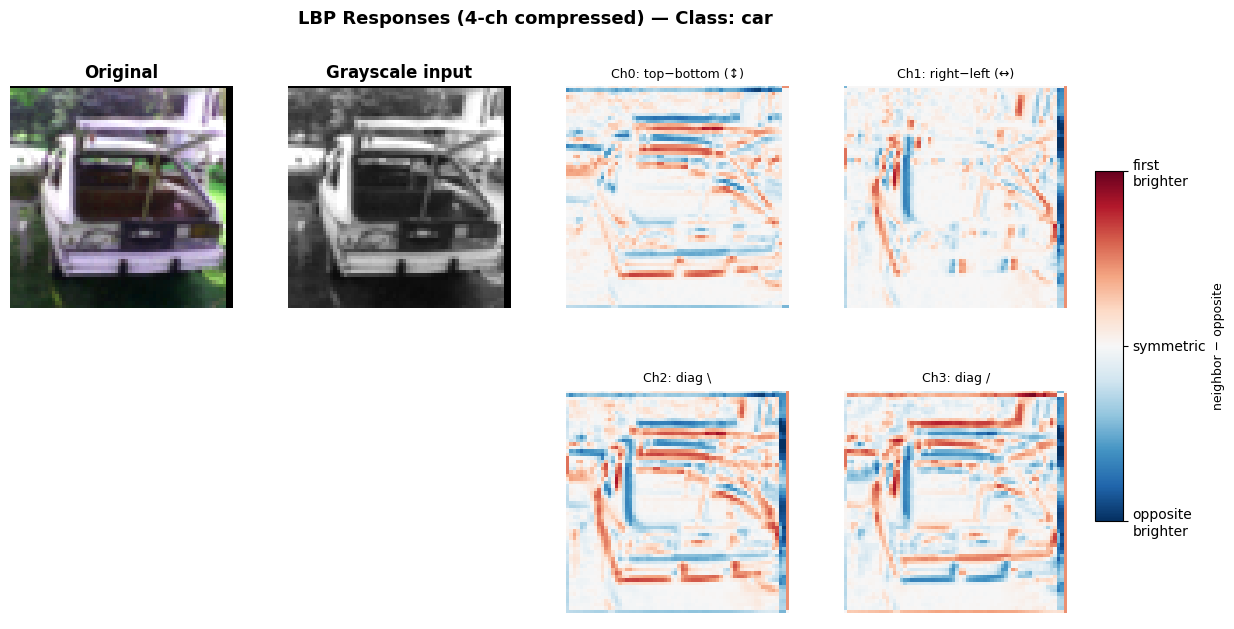

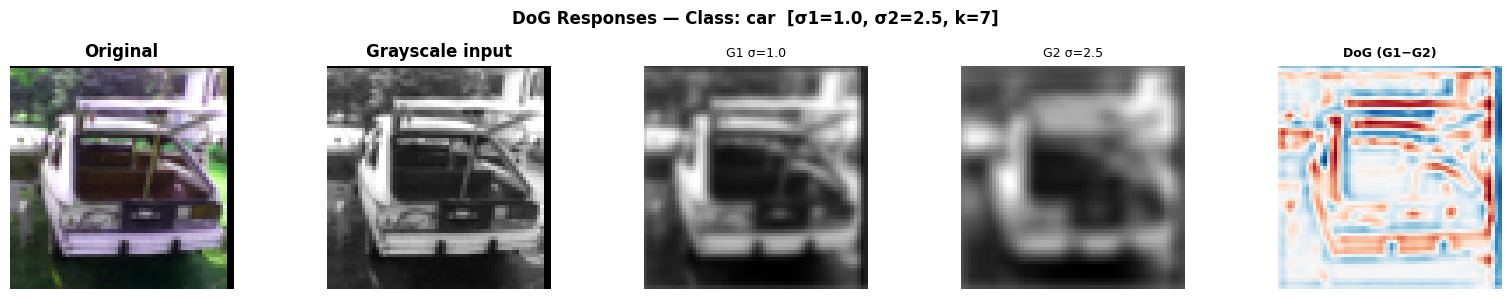

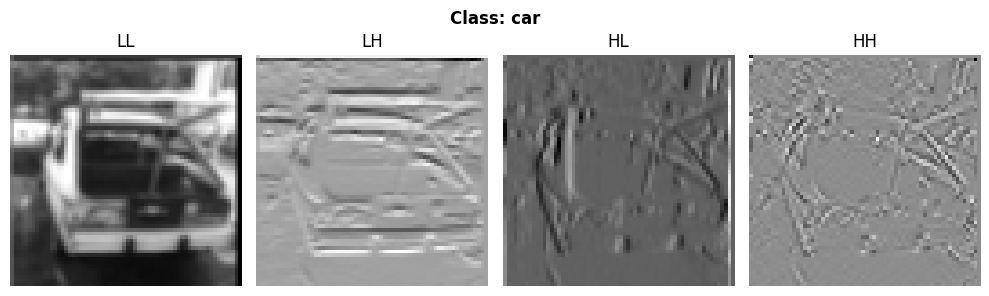

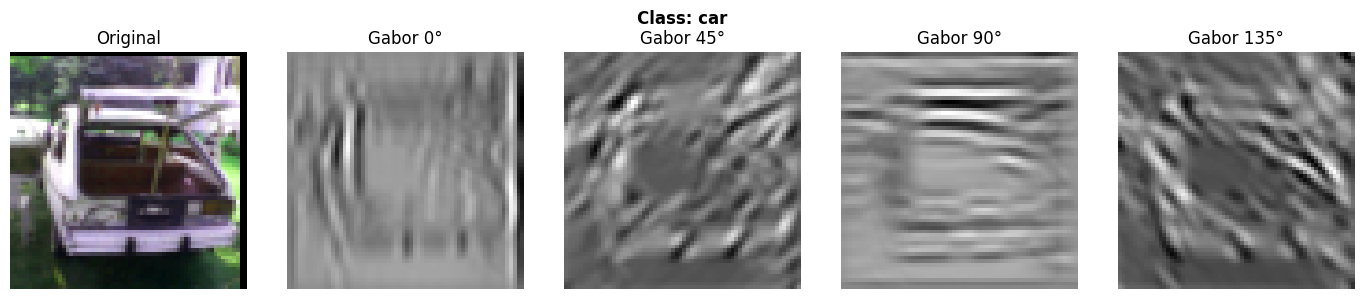

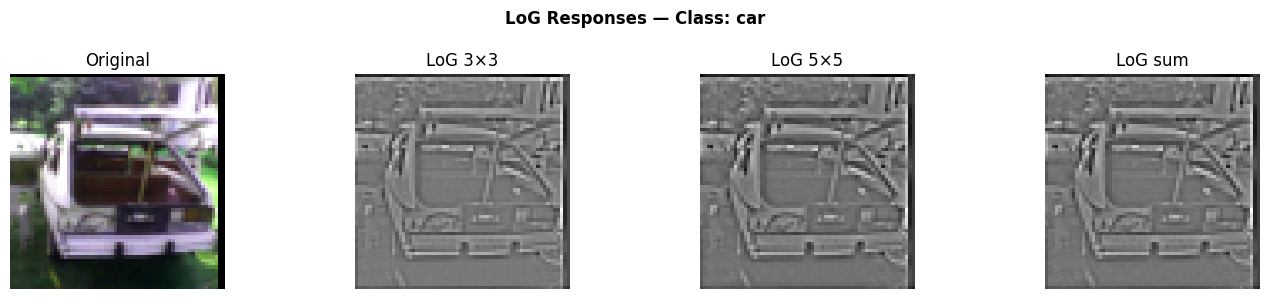

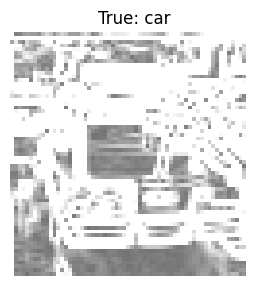

In [8]:
show_lbp_responses(x=images[3], y=labels[3], classes_str=class_names)
show_dog_responses(x=images[3], y=labels[3], classes_str=class_names)
show_wavelet_subbands(x=images[3], y=labels[3], classes_str=class_names)
show_gabor_responses(
    x=images[3],
    y=labels[3],
    classes_str=class_names,
    orientations=(0, 45, 90, 135),
    kernel_size=7,
)
show_log_responses(x=images[3], y=labels[3], classes_str=class_names)
x = apply_sobel_for_vis(images[3])
show_img_grayscale(X=x, y=labels[3], classes_str=class_names)


In [ ]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

# Low param 47.8k, 64x64

model_stl_train_1 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=12,
    filters=[FilterType.LOG, FilterType.LBP],
    tail_depth=1,
)

In [ ]:
print_model_summary(model=model_stl_train_1, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                                       [1, 3, 64, 64]            [1, 32, 16, 16]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                                 [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─MultiScaleDepthwis

In [ ]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_stl_train_1,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/stl_64x64_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 47,840 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 8 epochs → peak 2e-03 | Cosine: 92 epochs → 1.6e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 4.25e-04
  Epoch   3: 6.50e-04
  Epoch   4: 8.75e-04
  Epoch   5: 1.10e-03
  Epoch   9: 2.00e-03
  Epoch  98: 6.24e-06
  Epoch  99: 3.33e-06
  Epoch 100: 1.58e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)



Epoch   1/100 | LR: 0.00043
  Train  Acc: 21.40%  Loss: 2.2105
  Test   Acc: 11.04%  Loss: 2.3005
Best saved (Test Acc: 11.04%)
-----------------------------------
Epoch   2/100 | LR: 0.00065
  Train  Acc: 30.30%  Loss: 1.9464
  Test   Acc: 10.82%  Loss: 2.2652
-----------------------------------
Epoch   3/100 | LR: 0.00088
  Train  Acc: 37.36%  Loss: 1.8020
  Test   Acc: 20.56%  Loss: 2.2423
Best saved (Test Acc: 20.56%)
-----------------------------------
Epoch   4/100 | LR: 0.00110
  Train  Acc: 41.85%  Loss: 1.7115
  Test   Acc: 21.34%  Loss: 2.1803
Best saved (Test Acc: 21.34%)
-----------------------------------
Epoch   5/100 | LR: 0.00133
  Train  Acc: 47.33%  Loss: 1.6250
  Test   Acc: 24.79%  Loss: 2.1105
Best saved (Test Acc: 24.79%)
-----------------------------------
Epoch   6/100 | LR: 0.00155
  Train  Acc: 50.93%  Loss: 1.5615
  Test   Acc: 25.85%  Loss: 2.0329
Best saved (Test Acc: 25.85%)
-----------------------------------
Epoch   7/100 | LR: 0.00177
  Train  Acc: 52.8

In [8]:
tta_acc = evaluate_tta(
    model=model_stl_train_1, test_loader=test_dataloader, device=DEVICE
)
tta_acc

0.7722499966621399

Generating predictions for Confusion Matrix...


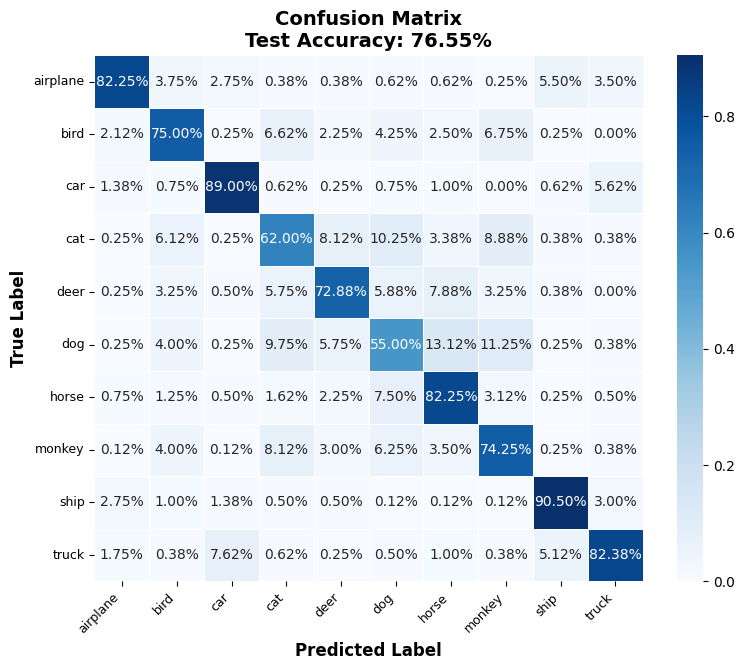


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'dog': 10.2%
  - True 'dog' predicted as 'horse': 13.1%
  - True 'dog' predicted as 'monkey': 11.2%


In [9]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_stl_train_1,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)


In [ ]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               76.55% 98.41%     47,843      11.9      0.17    5.00   199.9  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 76.55% Top-1 | 47,843 params | 5.00 ± 0.30 ms | 199.9 FPS



Saved → ../figure/solo/train_stl_64x64_47k.pdf / .png


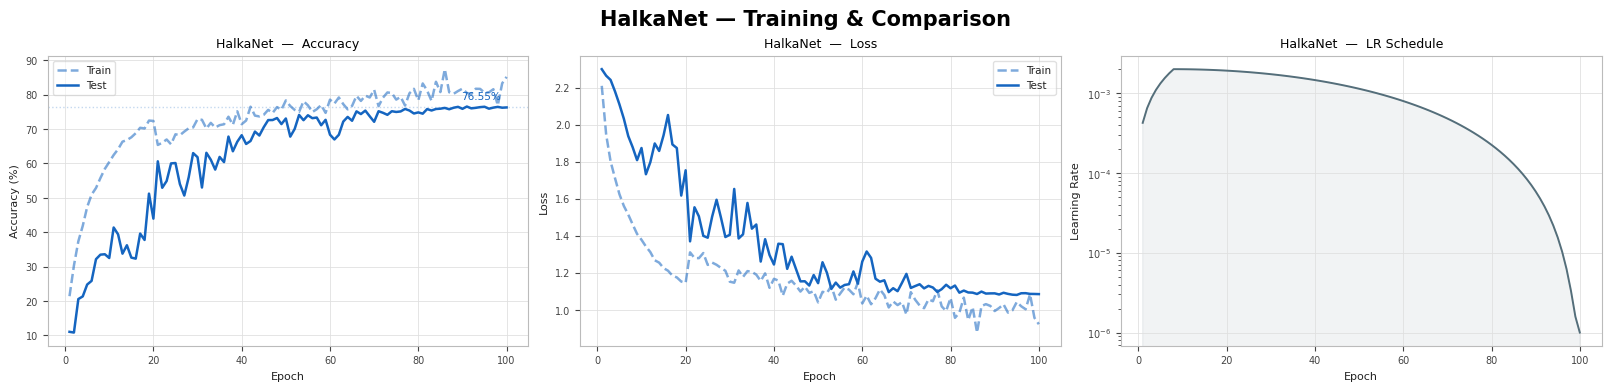

In [ ]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/solo/train_stl_64x64_47k.pdf",
    dataset_name="STL-10 Image Dataset",
    title="HalkaNet training:",
)

In [13]:
from utils import cleanup

cleanup(results, model_stl_train_1)

CUDA  Allocated 18.5 MB  Reserved 46.1 MB


In [5]:
from config import IMAGE_DIMENSION

train_dataset, test_dataset = download_stl10(img_dimensions=IMAGE_DIMENSION)

print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


STL-10 ready  train=5000  test=8000  channels=3

Dataset Statistics:
Training samples: 5000
Testing samples: 8000
Number of classes: 10
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [6]:
train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset, train_dataset=train_dataset, batch_size=64
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

DataLoader Information:
Train batches: 79
Test batches: 125


In [16]:
from utils import set_seed
from config import BranchType, FilterType
from models import HalkaNet

set_seed()

# Low param 47.8k, 96x96

model_stl_train_2 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=12,
    filters=[FilterType.LOG, FilterType.LBP],
    tail_depth=1,
)

In [17]:
print_model_summary(model=model_stl_train_2, img_dim=IMAGE_DIMENSION)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 96, 96]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 96, 96]            [1, 1, 96, 96]            (3)                       27,648
├─Sequential: 1-2                                       [1, 3, 96, 96]            [1, 32, 24, 24]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 96, 96]            [1, 16, 96, 96]           48                        442,368
│    └─BatchNorm2d: 2-2                                 [1, 16, 96, 96]           [1, 16, 96, 96]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 96, 96]           [1, 16, 96, 96]           --                        --
│    └─MultiScaleDepthwis

In [18]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_stl_train_2,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/stl_96x96_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 47,840 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 8 epochs → peak 2e-03 | Cosine: 92 epochs → 1.6e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 4.25e-04
  Epoch   3: 6.50e-04
  Epoch   4: 8.75e-04
  Epoch   5: 1.10e-03
  Epoch   9: 2.00e-03
  Epoch  98: 6.24e-06
  Epoch  99: 3.33e-06
  Epoch 100: 1.58e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00043
  Train  Acc: 21.91%  Loss: 2.2046
  Test   Acc: 12.40%  Loss: 2.3013
Best saved (Test Acc: 12.40%)
-----------------------------------
Epoch   2/100 | LR: 0.00065
  Train  Acc: 30.87%  Loss: 1.9300
  Test   Acc: 16.32%  Loss: 2.2751
Best saved (Test Acc: 16.32%)
-----------------------------------
Epoch   3/100 | LR: 0.00088
  Train  Acc: 38.13%  Loss: 1.7806
  Test   Acc: 21.41%  Loss: 2.2486
Best saved (Test Acc: 21.41%)
-----------------------------------
Epoch   4/100 | LR: 0.00110
  

In [19]:
tta_acc = evaluate_tta(
    model=model_stl_train_2, test_loader=test_dataloader, device=DEVICE
)
tta_acc

0.8109999895095825

Generating predictions for Confusion Matrix...


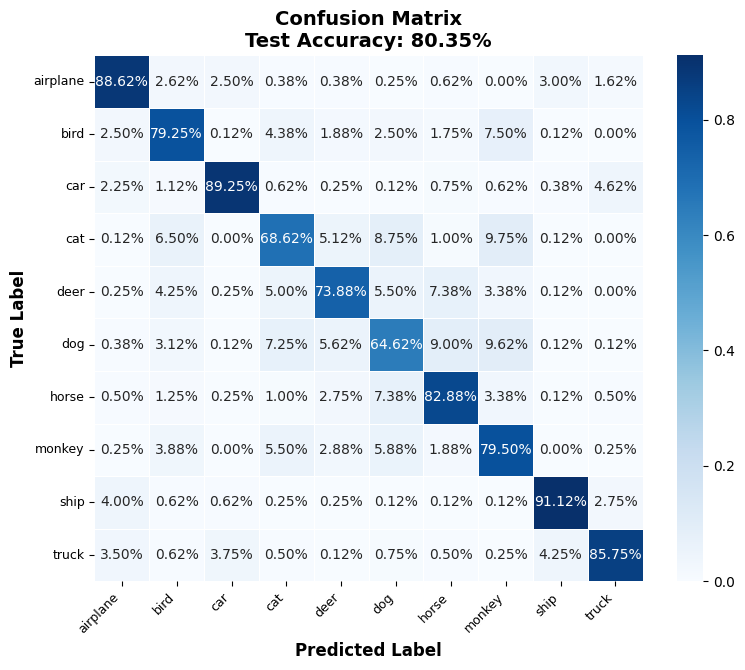


Most Confused Pairs (Errors > 10.00%):


In [20]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_stl_train_2,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)

In [21]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               80.35% 98.59%     47,843      26.8      0.17    8.96   111.6  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 80.35% Top-1 | 47,843 params | 8.96 ± 1.03 ms | 111.6 FPS



Saved → ../figure/solo/train_stl_96x96_47k.pdf / .png


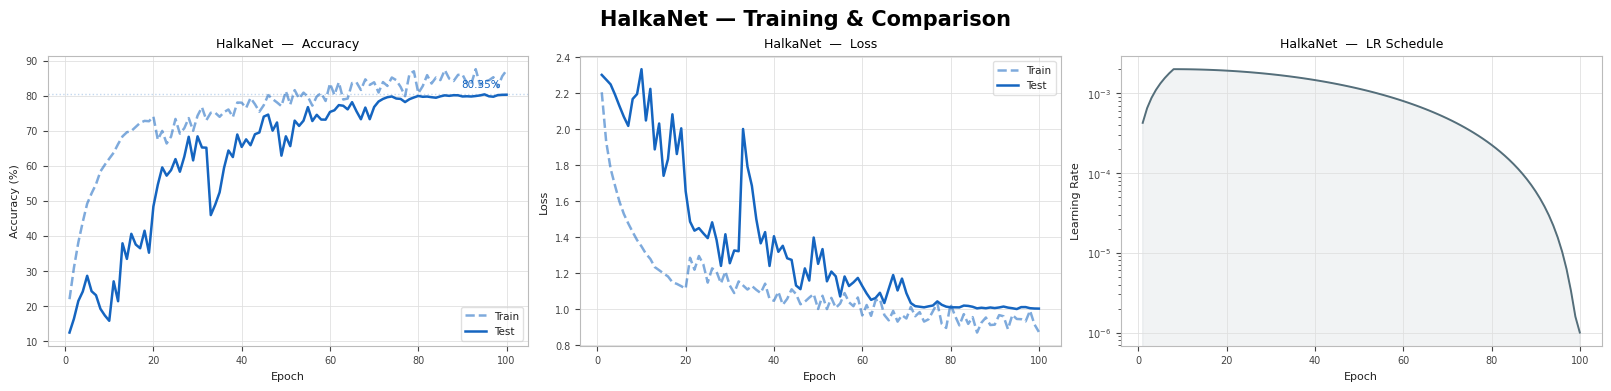

In [ ]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/solo/train_stl_96x96_47k.pdf",
    dataset_name="STL-10 Image Dataset",
    title="HalkaNet training:",
)


[plot_feature_space] Hooking layer: 'classifier_pool'
[plot_feature_space] Collecting up to 2000 TEST samples...
[plot_feature_space] ⚠  Using test_loader (no augmentation — clean features)
[plot_feature_space] Collected 2000 samples | feature dim = 120
[plot_feature_space] Running UMAP...


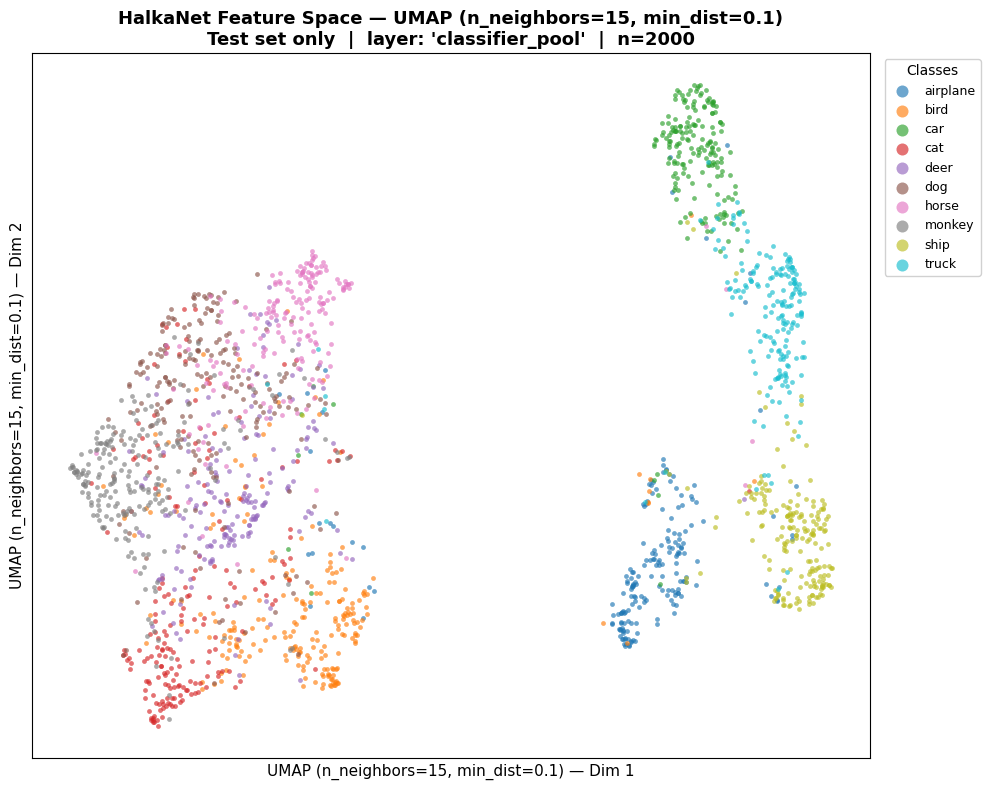

[plot_feature_space] Done.


In [24]:
from utils import plot_feature_space

plot_feature_space(
    model=model_stl_train_2,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    method="umap",
)


In [8]:
from utils import set_seed
from models import HalkaNet
from config import BranchType, FilterType, DEFAULT_SEED

set_seed(seed=DEFAULT_SEED)

model_stl_train = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1.2, BranchType.FILTER: 1},
    filter_channels=20,
    filters=[FilterType.LOG, FilterType.LBP, FilterType.WAVE],
    tail_depth=1,
)

In [9]:
from utils import print_model_summary

print_model_summary(model=model_stl_train, img_dim=IMAGE_DIMENSION_STL)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                                       [1, 3, 64, 64]            [1, 35, 16, 16]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                                 [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─MultiScaleDepthwis

In [10]:
from config import (
    BranchType,
    CHECKPOINT_DIR,
    EPOCHS_PRO_MAX,
    WEIGHT_DECAY,
    LABEL_SMOOTHING,
)
from utils import run_experiment

results = run_experiment(
    halkanet=model_stl_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/stl-10_96x96_model_hend",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 94,271 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 8 epochs → peak 2e-03 | Cosine: 92 epochs → 1.6e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 4.25e-04
  Epoch   3: 6.50e-04
  Epoch   4: 8.75e-04
  Epoch   5: 1.10e-03
  Epoch   9: 2.00e-03
  Epoch  98: 6.24e-06
  Epoch  99: 3.33e-06
  Epoch 100: 1.58e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00043
  Train  Acc: 23.52%  Loss: 2.1771
  Test   Acc: 10.71%  Loss: 2.3409
Best saved (Test Acc: 10.71%)
-----------------------------------
Epoch   2/100 | LR: 0.00065
  Train  Acc: 35.72%  Loss: 1.8493
  Test   Acc: 10.64%  Loss: 2.2879
-----------------------------------
Epoch   3/100 | LR: 0.00088
  Train  Acc: 42.98%  Loss: 1.7076
  Test   Acc: 10.50%  Loss: 2.2845
-----------------------------------
Epoch   4/100 | LR: 0.00110
  Train  Acc: 50.65%  Loss: 1.5907
  Test   Acc: 13.20%  Loss:

In [11]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)



────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               82.65% 98.59%     94,274      23.7      0.32    7.82   127.9  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 82.65% Top-1 | 94,274 params | 7.82 ± 1.19 ms | 127.9 FPS



Generating predictions for Confusion Matrix...


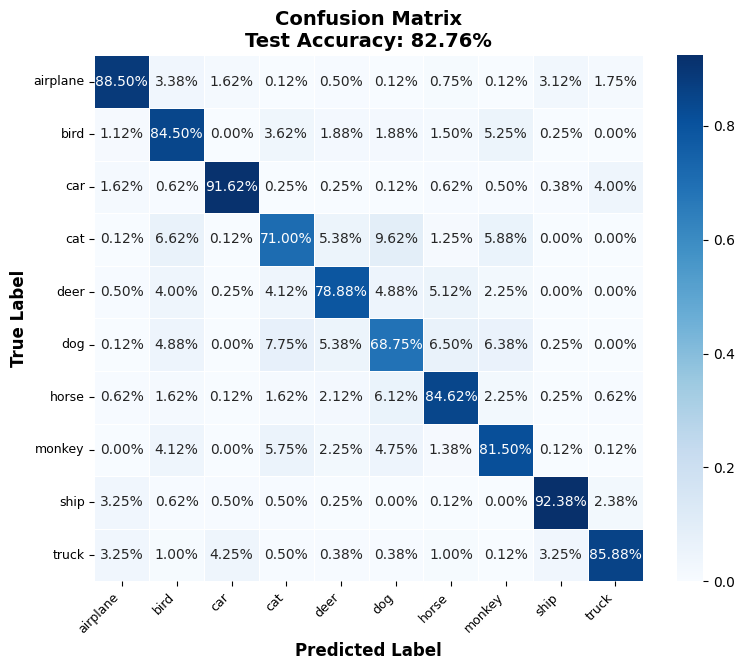


Most Confused Pairs (Errors > 10.00%):


In [19]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_stl_train,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)